### Exercise 5

Forecasting<br>
• Split real-world time series into train/test sets.<br>
• Fit ARIMA on training, forecast test observations.<br>
• Plot forecasts vs. actuals, what patterns does your model capture or miss?<br>
• Perform residual analysis<br>
• Generate 80% / 95% forecast intervals. Are values within the intervals? What does this imply?<br>

Evaluation workflow<br>
• Use cross-validation to generate different validation folds<br>
• Compute rolling forecast performance. Which metric is best suited for your data?<br>
• Compare ARIMA with baseline models (mean, naïve, seasonal naïve).<br>
• Review sktime forecasting notebook and test different forecasting approaches.<br>
• Select best model and evaluate performance on the test set.<br>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA as sm_ARIMA

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sktime.utils.plotting import plot_interval, plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA

from utils import time_plot, get_figure, baseline_forecasting, residual_analysis_plots, acf_plot, pacf_plot, stationarity_tests, split_time_series, evaluate_forecaster
from data import get_france_death_rate_20y

### Forecasting

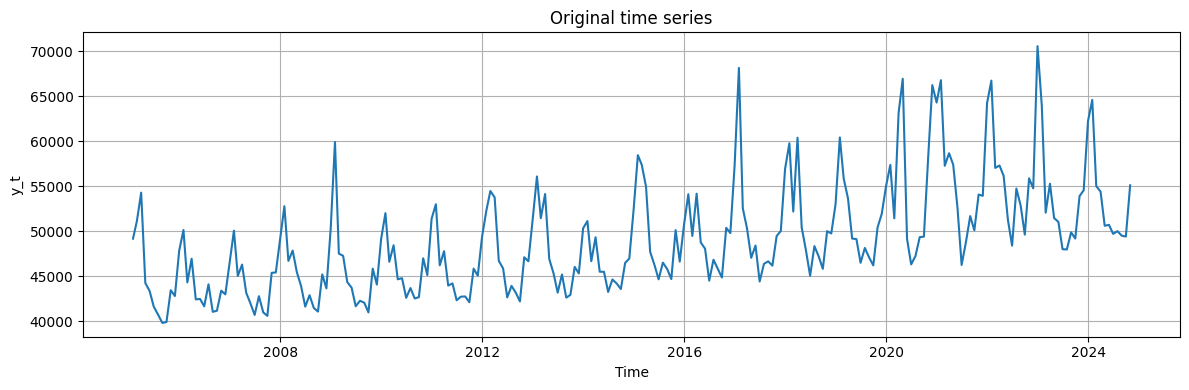

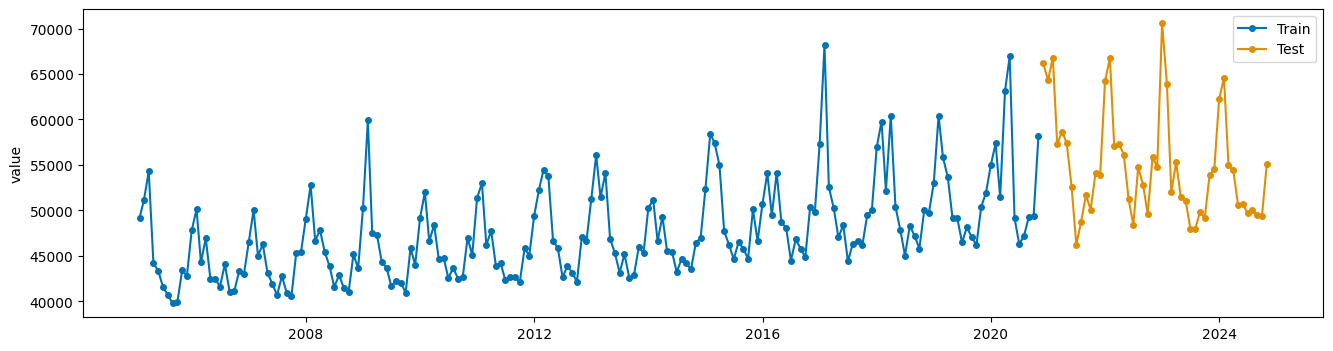

In [12]:

data = get_france_death_rate_20y()
data["time"] = pd.to_datetime(data["time"])

y = data.set_index("time")["value"]

fig, axes = get_figure()
ax = axes[0]

time_plot(
    x=y.index,
    y=y.values,
    title="Original time series",
    xlabel="Time",
    ylabel="y_t",
    ax=ax,
)
fig.tight_layout()

full_train, (train, eval), test = split_time_series(y)

plot_series(full_train, test, labels=['Train', 'Test'])

fh = list(range(len(test)))  # forecasting horizon for test period


In [13]:
stationarity_tests(y)

Stationarity Test Results:
	- ADF: Non-Stationary (p-value: 0.7629)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Non-Stationary (p-value: 0.0001)
	- ZA: Non-Stationary (p-value: 0.5844)


Stationarity Test Results:
	- ADF: Stationary (p-value: 0.0000)
	- PP: Stationary (p-value: 0.0000)
	- KPSS: Stationary (p-value: 0.9967)
	- ZA: Stationary (p-value: 0.0000)


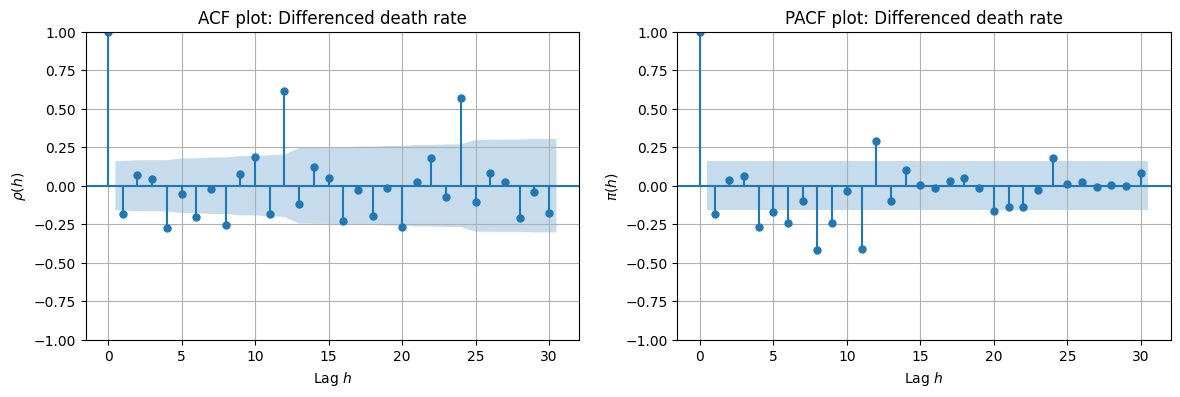

In [14]:
# Differencing 
differenced_data = train.diff().dropna()
stationarity_tests(differenced_data)

fig, (ax1, ax2) = get_figure(ncols=2, figsize=(14, 4))
acf_plot(differenced_data, 30, ax1, title="Differenced death rate")
pacf_plot(differenced_data, 30, ax2, title="Differenced death rate")



/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n00077

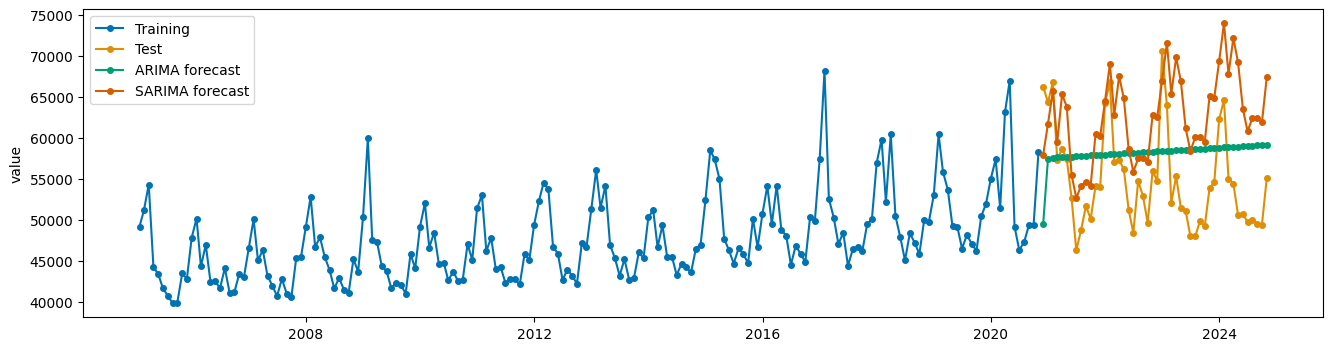

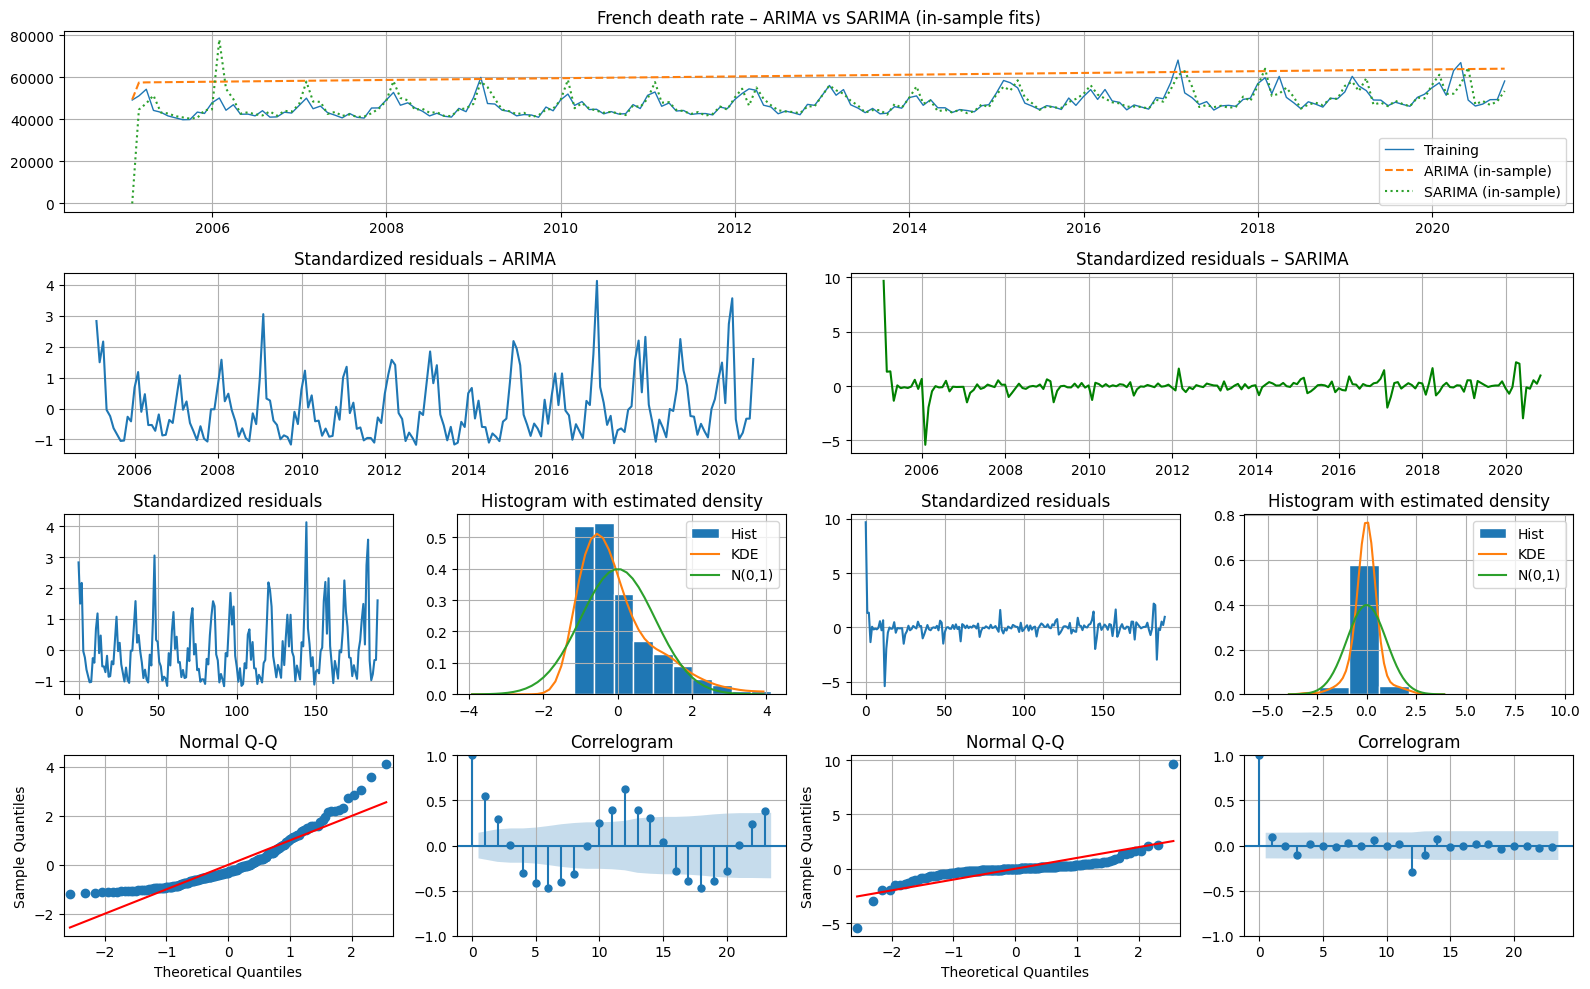

In [15]:
from sktime.forecasting.arima import ARIMA
from sktime.utils.plotting import plot_series

arima = ARIMA(order=(1, 1, 0))
arima.fit(full_train)
pred_arima = arima.predict(fh=fh)
pred_arima.index = test.index

# Seasonal period 12
sarima_model = sm.tsa.statespace.SARIMAX(
    full_train,
    order=(1, 1, 1),          
    seasonal_order=(1, 1, 1, 12),  
)
sarima_res = sarima_model.fit(disp=False)

# In-sample fitted values
fitted_sarima = sarima_res.fittedvalues

# Out-of-sample forecast for the test horizon
sarima_forecast = sarima_res.forecast(steps=len(test))
sarima_forecast = pd.Series(sarima_forecast, index=test.index)

plot_series(
    full_train,
    test,
    pred_arima,
    sarima_forecast,
    labels=["Training", "Test", "ARIMA forecast", "SARIMA forecast"],
)


fh_in_sample = np.arange(len(full_train))
arima_in_sample = arima.predict(fh=fh_in_sample)
arima_in_sample.index = full_train.index
resid_arima = full_train - arima_in_sample
resid_arima_std = (resid_arima - resid_arima.mean()) / resid_arima.std(ddof=1)

resid_sarima = sarima_res.resid
resid_sarima_std = (resid_sarima - resid_sarima.mean()) / resid_sarima.std(ddof=1)

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(4, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, :])      # top: original + fits
ax2 = fig.add_subplot(gs[1, :2])     # ARIMA residuals time plot
ax3 = fig.add_subplot(gs[1, 2:])     # SARIMA residuals time plot

arima_axs = [
    fig.add_subplot(gs[2, 0]),
    fig.add_subplot(gs[2, 1]),
    fig.add_subplot(gs[3, 0]),
    fig.add_subplot(gs[3, 1]),
]

sarima_axs = [
    fig.add_subplot(gs[2, 2]),
    fig.add_subplot(gs[2, 3]),
    fig.add_subplot(gs[3, 2]),
    fig.add_subplot(gs[3, 3]),
]

# training + ARIMA + SARIMA fits (on train index)
ax1.plot(full_train.index, full_train.values, label="Training", linewidth=1)
ax1.plot(full_train.index, arima_in_sample.values, label="ARIMA (in-sample)", linestyle="--")
ax1.plot(full_train.index, fitted_sarima.values, label="SARIMA (in-sample)", linestyle=":")
ax1.set_title("French death rate – ARIMA vs SARIMA (in-sample fits)")
ax1.legend()
ax1.grid(True)

# Time plots of standardized residuals
ax2.plot(resid_arima_std, label="ARIMA residuals")
ax2.set_title("Standardized residuals – ARIMA")
ax2.grid(True)

ax3.plot(resid_sarima_std, label="SARIMA residuals", color="green")
ax3.set_title("Standardized residuals – SARIMA")
ax3.grid(True)

# Residual analysis plots
residual_analysis_plots(resid_arima_std, axs=arima_axs)
residual_analysis_plots(resid_sarima_std, axs=sarima_axs)

fig.tight_layout()
plt.show()


The non-seasonal ARIMA model captures only the trend of the French death rate but fails to model its annual seasonal pattern. In contrast, the SARIMA model successfully captures seasonality. But it overestimates the trend of the series in the forecast horizon

/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, fr

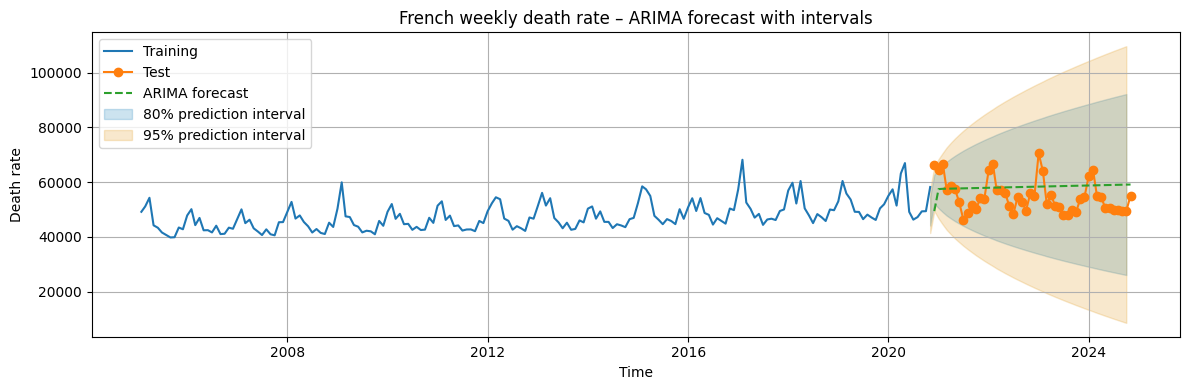

In [16]:
from sktime.utils.plotting import plot_interval

# Two coverages: 80% and 95%
pred_int = arima.predict_interval(fh=fh, coverage=[0.80, 0.95])

# Plot train, test, forecast, and intervals
fig, ax = time_plot(
    x=full_train.index,
    y=full_train,
    label="Training",
    title="French weekly death rate – ARIMA forecast with intervals",
    xlabel="Time",
    ylabel="Death rate",
    return_fig=True,
)

# Test observations
ax.plot(test.index, test, label="Test", marker="o")

# Point forecasts
ax.plot(pred_arima.index, pred_arima, label="ARIMA forecast", linestyle="--")

# Interval bands
plot_interval(ax, pred_int)

ax.legend()
fig.tight_layout()


#### Evaluation workflow

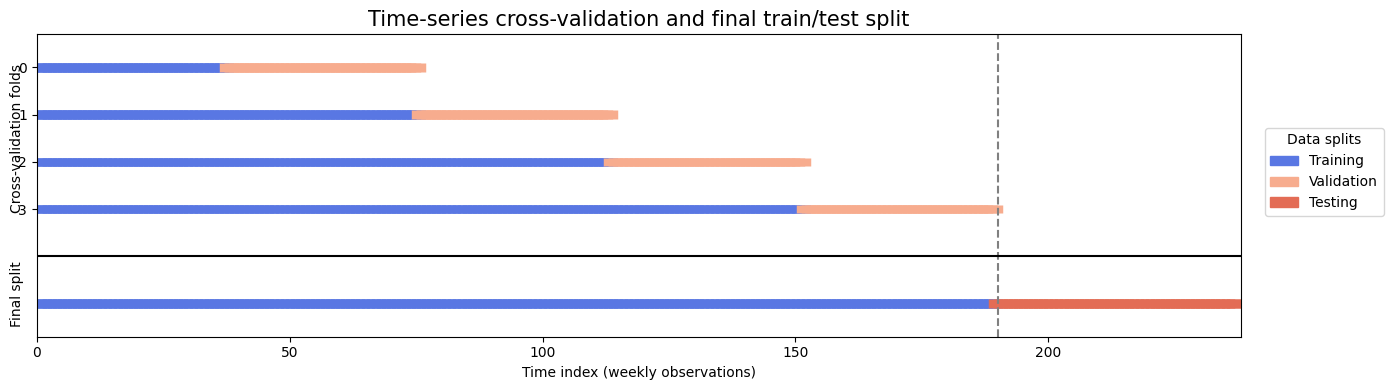

In [17]:
nsamples = len(y)
train_size = int(nsamples * 0.8)

samples = y.values
sample_index = np.arange(nsamples)

n_splits = 4
cv = TimeSeriesSplit(n_splits=n_splits)

cmap_cv = plt.cm.coolwarm
scatter_kwargs = {'lw': 14, 'marker': '|', 'cmap': cmap_cv, 'vmin': 0, 'vmax': 1}

fig, [ax] = get_figure(figsize=(14, 4))

# Cross-validation folds (on TRAIN only)
for ii, (tr, tt) in enumerate(cv.split(X=samples[:train_size])):
    indices = np.full(train_size, np.nan)
    indices[tr] = 0.1   # training
    indices[tt] = 0.7   # validation

    ax.scatter(
        range(train_size),
        [ii + 0.5] * train_size,
        c=indices,
        **scatter_kwargs,
    )

# Final train / test split
indices = np.zeros(nsamples) + 0.1       # train
indices[train_size:] = 0.85              # test

ax.scatter(
    range(nsamples),
    [ii + 2.5] * nsamples,
    c=indices,
    **scatter_kwargs,
)

# Formatting
ax.set(
    yticks=np.arange(n_splits) + 0.5,
    yticklabels=list(range(n_splits)),
    xlabel="Time index (weekly observations)",
    ylim=[n_splits + 2.2, -0.2],
    xlim=[0, nsamples],
)
ax.set_title("Time-series cross-validation and final train/test split", fontsize=15)

# Vertical line = start of test set
ax.axvline(x=train_size, color='gray', linestyle='--')

# Horizontal divider
ax.axhline(y=ii + 1.5, color='black', linestyle='-')

# Labels on the left
ax.text(-2.5, n_splits / 2, "Cross-validation folds", va='center', ha='right', rotation=90)
ax.text(-2.5, n_splits + 1.3, "Final split", va='center', ha='right', rotation=90)

ax.grid(False)

# Legend
ax.legend(
    [Patch(color=cmap_cv(0.1)), Patch(color=cmap_cv(0.7)), Patch(color=cmap_cv(0.85))],
    ["Training", "Validation", "Testing"],
    loc=(1.02, 0.4),
    title="Data splits"
)

fig.tight_layout()
plt.show()


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n00077

Rolling MAE:  3785.443
Rolling RMSE: 5221.483


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n00077

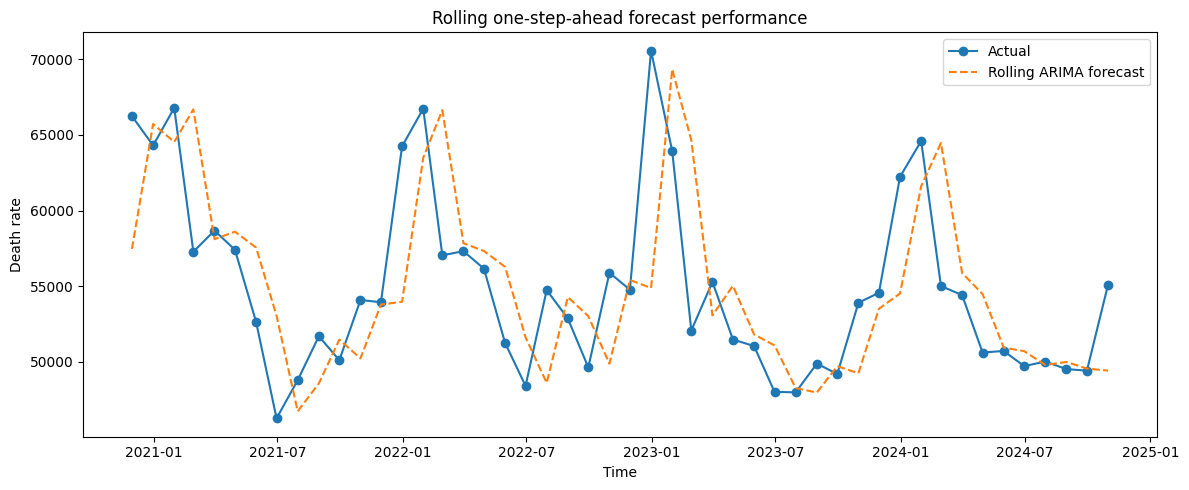

In [18]:
history = full_train.copy()
rolling_preds = []

for t in test.index:
    # Fit ARIMA on data available up to time t-1
    model = ARIMA(order=(1, 1, 0))
    model.fit(history)

    # One-step-ahead forecast
    y_hat = model.predict(fh=[1])[0]
    rolling_preds.append(y_hat)

    # Update history with the true observation
    history = pd.concat([history, test.loc[[t]]])

rolling_preds = pd.Series(rolling_preds, index=test.index)


errors = test - rolling_preds

mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))

print(f"Rolling MAE:  {mae:.3f}")
print(f"Rolling RMSE: {rmse:.3f}")


plt.figure(figsize=(12, 5))
plt.plot(test, label="Actual", marker="o")
plt.plot(rolling_preds, label="Rolling ARIMA forecast", linestyle="--")
plt.title("Rolling one-step-ahead forecast performance")
plt.xlabel("Time")
plt.ylabel("Death rate")
plt.legend()
plt.tight_layout()
plt.show()



In [19]:
n_splits = 4
cv = TimeSeriesSplit(n_splits=n_splits)

rmse_scores = []
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(full_train)):
    y_train = full_train.iloc[train_idx]
    y_val = full_train.iloc[val_idx]

    fh = np.arange(1, len(y_val) + 1)

    model = ARIMA(order=(1, 1, 0))
    model.fit(y_train)

    y_pred = model.predict(fh=fh)
    y_pred.index = y_val.index

    errors = y_val - y_pred

    rmse_scores.append(np.sqrt(np.mean(errors**2)))
    mae_scores.append(np.mean(np.abs(errors)))

print("CV RMSE per fold:", rmse_scores)
print("CV MAE  per fold:", mae_scores)
print("Mean CV RMSE:", np.mean(rmse_scores))
print("Mean CV MAE :", np.mean(mae_scores))


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n00077

CV RMSE per fold: [np.float64(4272.842403783216), np.float64(6100.447255943808), np.float64(8926.903869003143), np.float64(7784.390048374174)]
CV MAE  per fold: [np.float64(3178.6892215804583), np.float64(4777.716384916936), np.float64(7276.499807515367), np.float64(5783.114387922867)]
Mean CV RMSE: 6771.1458942760855
Mean CV MAE : 5254.004950483907


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n00077

In [20]:

history = full_train.copy()
rolling_preds = []

for t in test.index:
    model = ARIMA(order=(1, 1, 0))
    model.fit(history)

    y_hat = model.predict(fh=[1])[0]
    rolling_preds.append(y_hat)

    history = pd.concat([history, test.loc[[t]]])

rolling_preds = pd.Series(rolling_preds, index=test.index)

errors = test - rolling_preds

rmse_rolling = np.sqrt(np.mean(errors**2))
mae_rolling = np.mean(np.abs(errors))

print("Rolling RMSE:", rmse_rolling)
print("Rolling MAE :", mae_rolling)


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n00077

Rolling RMSE: 5221.482656539612
Rolling MAE : 3785.4432443410756


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n00077

/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_base.py:1250: UserWarning: empty y passed to update_predict of NaiveForecaster(strategy='drift'), no update was carried out
  warn(
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794

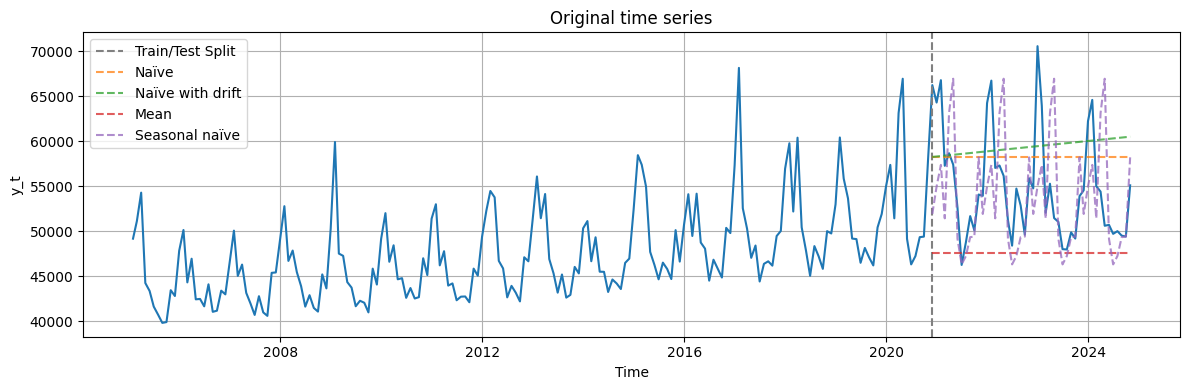

In [21]:

data = get_france_death_rate_20y()
data["time"] = pd.to_datetime(data["time"])

y = data.set_index("time")["value"]

# Infer the frequency from the dates and set it
freq = pd.infer_freq(y.index)

if freq is not None:
    y = y.asfreq(freq)
else:
    # Fallback
    y = y.asfreq("M")  

fig, axes = get_figure()
ax = axes[0]

time_plot(
    x=y.index,
    y=y.values,
    title="Original time series",
    xlabel="Time",
    ylabel="y_t",
    ax=ax,
)

train_size = int(len(data) * 0.8)

ax.axvline(
    x=y.index[train_size],
    color="gray",
    linestyle="--",
    label="Train/Test Split"
)

baselines = baseline_forecasting(y, train_size, period=12)

for name, (_, pred, _) in baselines.items():
    ax.plot(pred.index, pred, label=name, linestyle="--", alpha=0.75)

ax.legend(loc="upper left")
fig.tight_layout()


In [22]:
print(full_train.head())

2005-01-31    49165.0
2005-02-28    51122.0
2005-03-31    54284.0
2005-04-30    44233.0
2005-05-31    43350.0
Name: value, dtype: float64


In [23]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction

fh = np.arange(1, len(test) + 1)

rf_regressor = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
)

rf_forecaster = make_reduction(
    estimator=rf_regressor,
    strategy="recursive",
    window_length=12,      # last 12 points as features
    scitype="tabular-regressor",
)

rf_forecaster.fit(full_train)
y_pred_rf = rf_forecaster.predict(fh=fh)
y_pred_rf.index = test.index



/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)


In [24]:
import numpy as np
import pandas as pd

y = data  # if data is already a Series
if isinstance(data, pd.DataFrame):
    y = data.set_index("time")["value"]

y = y.sort_index()
y.index = pd.to_datetime(y.index)

# 80/20 split
train_size = int(len(y) * 0.8)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

# Forecast horizon for all models
fh = np.arange(1, len(y_test) + 1)

print(len(y_train), len(y_test))
print(y_train.head())
print(y_test.head())


190 48
time
2005-01-31    49165.0
2005-02-28    51122.0
2005-03-31    54284.0
2005-04-30    44233.0
2005-05-31    43350.0
Name: value, dtype: float64
time
2020-11-30    66246.0
2020-12-31    64304.0
2021-01-31    66794.0
2021-02-28    57270.0
2021-03-31    58669.0
Name: value, dtype: float64


In [25]:
from sktime.forecasting.naive import NaiveForecaster

# Ensure y_train has a frequency set
if y_train.index.freq is None:
	y_train = y_train.asfreq(pd.infer_freq(y_train.index) or "M")

baselines = {}

# Mean forecaster
mean_f = NaiveForecaster(strategy="mean")
mean_f.fit(y_train)
y_pred_mean = mean_f.predict(fh=fh)
y_pred_mean.index = y_test.index
baselines["Mean"] = y_pred_mean

# Naïve (last observed value)
naive_f = NaiveForecaster(strategy="last")
naive_f.fit(y_train)
y_pred_naive = naive_f.predict(fh=fh)
y_pred_naive.index = y_test.index
baselines["Naive"] = y_pred_naive

# Seasonal naïve – monthly data → sp=12
seasonal_f = NaiveForecaster(strategy="last", sp=12)
seasonal_f.fit(y_train)
y_pred_seasonal = seasonal_f.predict(fh=fh)
y_pred_seasonal.index = y_test.index
baselines["Seasonal Naive"] = y_pred_seasonal


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, fr

In [26]:
from sktime.forecasting.arima import ARIMA

arima_model = ARIMA(order=(1, 1, 0))
arima_model.fit(y_train)
y_pred_arima = arima_model.predict(fh=fh)
y_pred_arima.index = y_test.index


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, fr

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Monthly data → seasonal period 12
sarima_model = SARIMAX(
    y_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
sarima_res = sarima_model.fit(disp=False)

y_pred_sarima = sarima_res.forecast(steps=len(y_test))
y_pred_sarima = pd.Series(y_pred_sarima, index=y_test.index, name="SARIMA")


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction

rf_regressor = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
)

rf_forecaster = make_reduction(
    estimator=rf_regressor,
    strategy="recursive",
    window_length=12,            # last 12 months as features
    scitype="tabular-regressor", 
)

rf_forecaster.fit(y_train)
y_pred_rf = rf_forecaster.predict(fh=fh)
y_pred_rf.index = y_test.index


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)


In [29]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

exp_model = ExponentialSmoothing(trend="add", seasonal="add", sp=12)
exp_model.fit(y_train)
y_pred_exp = exp_model.predict(fh=fh)
y_pred_exp.index = y_test.index


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, fr

In [30]:
from sktime.forecasting.theta import ThetaForecaster

# Convert y_train to PeriodIndex if necessary
if not isinstance(y_train.index, pd.PeriodIndex):
	freq = pd.infer_freq(y_train.index)
	# Replace 'ME' with 'M' for compatibility with PeriodIndex
	if freq == 'ME':
		freq = 'M'
	elif freq is None:
		freq = "M"
	y_train_period = y_train.copy()
	y_train_period.index = pd.to_datetime(y_train_period.index).to_period(freq)
else:
	y_train_period = y_train

theta_model = ThetaForecaster(sp=12)
theta_model.fit(y_train_period)

y_pred_theta = theta_model.predict(fh=fh)
if isinstance(y_pred_theta.index, pd.PeriodIndex):
	y_pred_theta.index = y_pred_theta.index.to_timestamp(how="end")

# Ensure the final index matches y_test
y_pred_theta.index = y_test.index


In [31]:
from sktime.forecasting.ets import AutoETS

# Let AutoETS pick the best ETS (error/trend/seasonal) model
ets_model = AutoETS(auto=True, sp=12, n_jobs=-1)
ets_model.fit(y_train)
y_pred_ets = ets_model.predict(fh=fh)
y_pred_ets.index = y_test.index


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, fr

In [32]:
from sktime.forecasting.trend import PolynomialTrendForecaster


poly_model = PolynomialTrendForecaster(degree=1)
poly_model.fit(y_train)
y_pred_poly = poly_model.predict(fh=fh)
y_pred_poly.index = y_test.index


/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:863: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return r * to_offset(fh.freq)
/Users/hslu-n0007794/Documents/HS25/TIME/venv/lib/python3.14/site-packages/sktime/forecasting/base/_fh.py:877: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  absolute = pd.DatetimeIndex(absolute, freq=fh.freq)


In [33]:
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

preds = {
    "Mean": y_pred_mean,
    "Naive": y_pred_naive,
    "Seasonal Naive": y_pred_seasonal,
    "ARIMA": y_pred_arima,
    "SARIMA": y_pred_sarima,
    "Random Forest": y_pred_rf,
    "ExpSmoothing": y_pred_exp,
    "Theta": y_pred_theta,
    "AutoETS": y_pred_ets,
    "PolyTrend": y_pred_poly,
}

rows = []
for name, y_hat in preds.items():
    mae = mean_absolute_error(y_test, y_hat)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    rows.append({"Model": name, "MAE": mae, "RMSE": rmse})

results = pd.DataFrame(rows).set_index("Model").sort_values("RMSE")
print(results)


                        MAE         RMSE
Model                                   
Theta           2479.747916  3555.188374
ExpSmoothing    3043.203043  4053.683863
SARIMA          2882.286166  4161.413050
AutoETS         4558.513044  5192.056062
PolyTrend       4792.383524  6425.093844
Seasonal Naive  5020.000000  6660.481086
Naive           6052.958333  6768.044754
ARIMA           6238.877021  6985.237680
Random Forest   6917.381250  7603.144425
Mean            7398.072807  9427.455780


In [34]:
best_name = results.index[0]
print("Best model:", best_name)

best_pred = preds[best_name]


Best model: Theta


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='value'>)

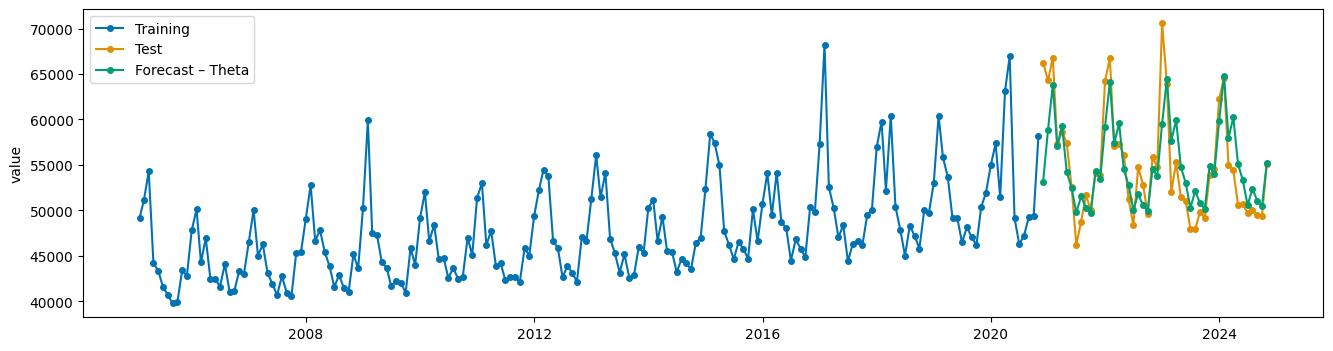

In [35]:
from sktime.utils.plotting import plot_series

plot_series(
    y_train,
    y_test,
    best_pred,
    labels=["Training", "Test", f"Forecast – {best_name}"],
)
